## Inference

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
import numpy as np
from torchvision import models
from torchvision import ops
from torchvision.models.detection import rpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from coco_dataset import COCODataset_Aug
from transform_util import Compose, RandomHorizontalFlip, PILToTensor, ToDtype, RandomPhotometricDistort
from torch.utils.data import DataLoader

from utils import *
from make_args import Args

from PIL import Image
import cv2
from tqdm import tqdm

from eval_utils.metric import get_inference_metrics_from_df, summarise_inference_metrics
from eval_utils.coco_metric import get_coco_from_dfs

import pandas as pd

- load config json

In [17]:
# load config.json
args = Args('./config/02_Aug_VGG_Backbone.json')

- validation dataset

In [18]:
def collator(batch):
    return tuple(zip(*batch))

In [19]:
val_transform = Compose(
    [
        PILToTensor(),
        ToDtype(scale=True, dtype=torch.float)
    ]
)
val_dataset = COCODataset_Aug(args.data_path, train=False, transform=val_transform)
val_dataloader = DataLoader(
    val_dataset, batch_size=1, shuffle=True, drop_last=True, collate_fn=collator, num_workers=args.num_workers
)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


- 모델 로드

In [20]:
weights_path = './model_result/02_Aug_VGG_Backbone/Augment_VGG_model.pth'
weights = torch.load(weights_path)
device = "cuda" if torch.cuda.is_available() else "cpu"

if args.backbone == 'vgg16':
    backbone = models.vgg16(weights="VGG16_Weights.IMAGENET1K_V1").features
    backbone.out_channels = 512

    anchor_generator = rpn.AnchorGenerator(sizes=(args.anchor_sizes,), aspect_ratios=(args.anchor_ratio,))
    roi_pooler = ops.MultiScaleRoIAlign(featmap_names=["0"], output_size=args.pooler_output_size, sampling_ratio=args.pooler_sampling_ratio)

    model = FasterRCNN(backbone=backbone, 
                       num_classes=len(val_dataset._get_categories()), 
                       rpn_anchor_generator=anchor_generator, 
                       box_roi_pool=roi_pooler ).to(device)
    
elif args.backbone == 'resnet50fpn':
    backbone = resnet_fpn_backbone('resnet50', pretrained=True)
    model = FasterRCNN(backbone, num_classes=len(val_dataset._get_categories())).to('cuda')

model.load_state_dict(weights)
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

- loss check

In [6]:
loss_dict = np.load('./model_result/03_Aug_ResNet50FPN_Backbone/Augment_ResNet50FPN_model.npy', allow_pickle=True).item()

In [7]:
loss_dict

{'train_loss': [0.8836617045280374,
  0.7505376952569304,
  0.7160477692578768,
  0.6977532844177728,
  0.6853717464558716,
  0.6757987771467389,
  0.6667532314960539,
  0.6584337467887093,
  0.6507186315062183,
  0.6421114512480188,
  0.6337348937470837,
  0.6249410708590291,
  0.6161962948474707,
  0.6068364666366455,
  0.5980740758882797,
  0.5891001153064325,
  0.5815566224739238],
 'val_loss': [0.7742810161221586,
  0.7308051543060528,
  0.7085613308050136,
  0.6948343358681159,
  0.6887517673277893,
  0.684090534270243,
  0.6790916125782087,
  0.6693359991604754,
  0.6638457660889779,
  0.6486705519283049,
  0.6490514394142612,
  0.6426325617704137,
  0.6343608669130213,
  0.6186253867670292,
  0.6251016822259915,
  0.6231708032694406,
  0.617898607767986]}

- inference

In [8]:
_cate_dict = val_dataset.new_categories
cate_dict = {}
for key, value in _cate_dict.items():
    cate_dict[value] = key

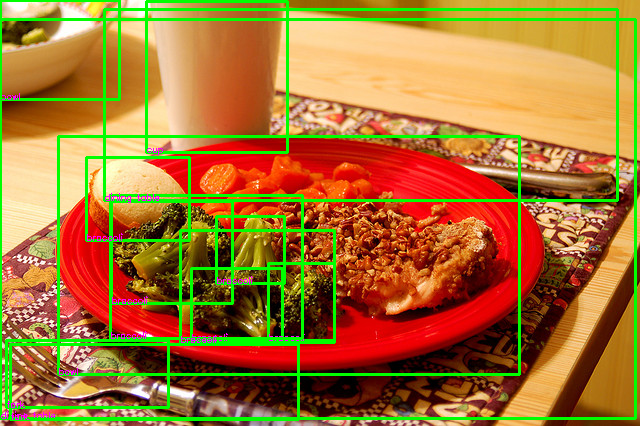

In [9]:
se_idx = 205
threshold = 0.5
with torch.no_grad():
    image, target = val_dataset[se_idx]
    image = [image.to(device)]
    outputs = model(image)

    boxes = outputs[0]["boxes"].to("cpu").numpy()
    labels = outputs[0]["labels"].to("cpu").numpy()
    scores = outputs[0]["scores"].to("cpu").numpy()

    boxes = boxes[scores >= threshold].astype(np.int32)
    labels = labels[scores >= threshold]
    scores = scores[scores >= threshold]

    gtboxes = target["boxes"].numpy()
    gtlabels = target["labels"].numpy()

draw_img = np.uint8(np.transpose(image[0].data.cpu().numpy(), (1, 2, 0)) * 255)
for i, bbox in enumerate(boxes):
    cv2.rectangle(draw_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
    cv2.putText(draw_img, cate_dict[labels[i]], (bbox[0], bbox[3]), cv2.FONT_ITALIC, 0.3, (255, 0, 255))
Image.fromarray(draw_img)

- gt image view

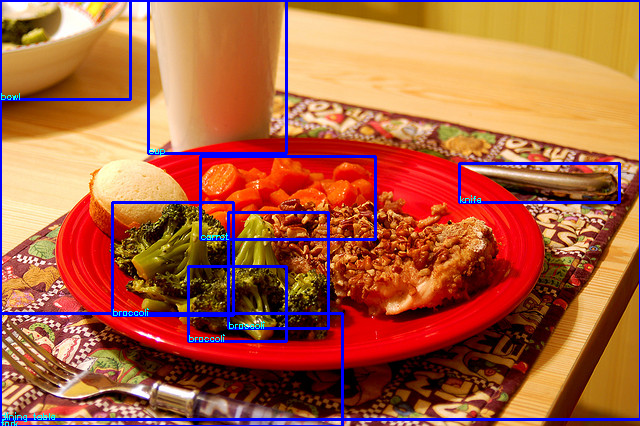

In [10]:
gt_draw_img = np.uint8(np.transpose(image[0].data.cpu().numpy(), (1, 2, 0)) * 255)
gt_boxes = target['boxes'].data.cpu().numpy().astype(np.int32)
gt_labels = target['labels'].data.cpu().numpy()

for i, bbox in enumerate(gt_boxes):
    cv2.rectangle(gt_draw_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 2)
    cv2.putText(gt_draw_img, cate_dict[gt_labels[i]], (bbox[0], bbox[3]), cv2.FONT_ITALIC, 0.3, (0, 255, 255))
Image.fromarray(gt_draw_img)

## Evaluation

In [21]:
gt_lists = []
pred_lists = []
stop_flag = 0

with torch.no_grad():
    model.eval()
    fileidx = 1
    # stop_flag += 1
    for images, targets in tqdm(val_dataloader, total=len(val_dataloader)):
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        # filename (arbitraily)
        filename = str(fileidx).zfill(6) + '.jpg'
        fileidx += 1
        
        # gt 작업
        gt_boxes = targets[0]['boxes'].data.cpu().numpy()
        gt_labels = targets[0]['labels'].data.cpu().numpy()

        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            x, y, w, h = gt_box
            x_min, y_min, x_max, y_max = x, y, x+w, y+h
            gt_list = [x_min, y_min, x_max, y_max, cate_dict[gt_label], filename]
            gt_lists.append(gt_list)

        # inference 작업
        pred_boxes = outputs[0]['boxes'].data.cpu().numpy()
        pred_labels = outputs[0]['labels'].data.cpu().numpy()
        pred_scores = outputs[0]['scores'].data.cpu().numpy()

        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
            x, y, w, h = pred_box
            x_min, y_min, x_max, y_max = x, y, x+w, y+h
            pred_list = [x_min, y_min, x_max, y_max, cate_dict[pred_label], pred_score, filename]
            pred_lists.append(pred_list)

        # stop_flag += 1
        # if stop_flag == 300:
        #     break

100%|██████████| 4952/4952 [02:28<00:00, 33.39it/s]


- make dataframe

In [22]:
gt_lists = np.array(gt_lists)
pred_lists = np.array(pred_lists)

preds_df = pd.DataFrame()
preds_df['xmin'] = np.array(pred_lists[:,0], dtype=np.float32)
preds_df['ymin'] = np.array(pred_lists[:,1], dtype=np.float32)
preds_df['xmax'] = np.array(pred_lists[:,2], dtype=np.float32)
preds_df['ymax'] = np.array(pred_lists[:,3], dtype=np.float32)
preds_df['label'] = pred_lists[:,4]
preds_df['score'] = np.array(pred_lists[:,5], dtype=np.float32)
preds_df['image_name'] = pred_lists[:,6]

labels_df = pd.DataFrame()
labels_df['xmin'] = np.array(gt_lists[:,0], dtype=np.float32)
labels_df['ymin'] = np.array(gt_lists[:,1], dtype=np.float32)
labels_df['xmax'] = np.array(gt_lists[:,2], dtype=np.float32)
labels_df['ymax'] = np.array(gt_lists[:,3], dtype=np.float32)
labels_df['label'] = gt_lists[:,4]
labels_df['image_name'] = gt_lists[:,5]

- custom evaluation

In [23]:
infer_df = get_inference_metrics_from_df(preds_df, labels_df)
class_summary_df = summarise_inference_metrics(infer_df)

"None of [Index(['000860.jpg'], dtype='object', name='image_name')] are in the [index]"
"None of [Index(['003353.jpg'], dtype='object', name='image_name')] are in the [index]"


In [24]:
class_summary_df

,class,TP,FP,FN,Total,Precision,Recall
0,airplane,378,264,3,645,0.588785,0.992126
1,apple,399,394,51,844,0.503153,0.886667
2,backpack,573,918,73,1564,0.384306,0.886997
3,banana,1027,448,37,1512,0.696271,0.965226
4,baseball bat,195,190,33,418,0.506494,0.855263
...,...,...,...,...,...,...,...
75,tv,488,491,34,1013,0.498468,0.934866
76,umbrella,762,594,65,1421,0.561947,0.921403
77,vase,507,802,30,1339,0.387319,0.944134
78,wine glass,540,471,46,1057,0.534125,0.921502


- coco evaluation

In [25]:
res = get_coco_from_dfs(preds_df, labels_df, False)

"None of [Index(['000860.jpg'], dtype='object', name='image_name')] are in the [index]"
"None of [Index(['003353.jpg'], dtype='object', name='image_name')] are in the [index]"
creating index...
index created!
Loading and preparing results...
DONE (t=0.53s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=22.00s).
Accumulating evaluation results...
DONE (t=4.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.150
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.309
 Average Recall   